In [68]:
import numpy as np
from mlxtend.preprocessing import shuffle_arrays_unison
import matplotlib.pyplot as plt
import time
import pandas as pd

In [69]:
import numpy as np

class CustomLayer:
    def __init__(self):
        self.input_data = None
        self.output_data = None

    def forward_pass(self, input_data):
        raise NotImplementedError

    def backward_pass(self, output_gradient):
        raise NotImplementedError

class CustomSequential(CustomLayer):
    def __init__(self):
        super().__init__()
        self.layers_list = []

    def add_layer(self, layer):
        self.layers_list.append(layer)

    def forward_pass(self, X):
        for layer in self.layers_list:
            X = layer.forward_pass(X)
        return X

    def backward_pass(self, output_gradient):
        for layer in reversed(self.layers_list):
            output_gradient = layer.backward_pass(output_gradient)
            
    # Save and load weights for all layers in the network
    def save_model_weights(self, filename_prefix):
        for i, layer in enumerate(self.layers_list):
            if hasattr(layer, 'weights'):
                np.save(f'{filename_prefix}_layer_{i}_weights.npy', layer.weights)
                np.save(f'{filename_prefix}_layer_{i}_bias.npy', layer.bias)

    def load_model_weights(self, filename_prefix):
        for i, layer in enumerate(self.layers_list):
            if hasattr(layer, 'weights'):
                layer.weights = np.load(f'{filename_prefix}_layer_{i}_weights.npy')
                layer.bias = np.load(f'{filename_prefix}_layer_{i}_bias.npy')

class CustomLinearLayer(CustomLayer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(input_size, output_size)
        self.bias = np.zeros((1, output_size))

    def forward_pass(self, input_data):
        self.input_data = input_data
        self.output_data = np.dot(input_data, self.weights) + self.bias
        return self.output_data

    def backward_pass(self, output_gradient):
        input_gradient = np.dot(output_gradient, self.weights.T)
        weights_gradient = np.dot(self.input_data.T, output_gradient)
        bias_gradient = np.sum(output_gradient, axis=0, keepdims=True)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * bias_gradient
        return input_gradient

class CustomSigmoidLayer(CustomLayer):
    def __init__(self):
        super().__init__()

    def sigmoid_activation(self, x):
        return 1 / (1 + np.exp(-x))

    def forward_pass(self, input_data):
        self.input_data = input_data
        self.output_data = self.sigmoid_activation(input_data)
        return self.output_data

    def backward_pass(self, output_gradient):
        sigmoid_gradient = self.output_data * (1 - self.output_data)
        input_gradient = sigmoid_gradient * output_gradient
        return input_gradient


class CustomTanhLayer(CustomLayer):
    def forward_pass(self, input_data):
        self.input_data = input_data
        self.output_data = np.tanh(input_data)
        return self.output_data

    def backward_pass(self, output_gradient):
        return output_gradient * (1 - self.output_data**2)

class CustomSoftmaxLayer(CustomLayer):
    def forward_pass(self, input_data):
        self.input_data = input_data
        exp_input = np.exp(input_data - np.max(input_data, axis=1, keepdims=True))  
        self.output_data = exp_input / np.sum(exp_input, axis=1, keepdims=True)
        return self.output_data

    def backward_pass(self, output_gradient):
        return output_gradient

class CustomCrossEntropyLossLayer(CustomLayer):
    def __init__(self):
        super().__init__()
        self.target_data = None

    def forward_pass(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data
        epsilon = 1e-15  
        loss_value = -np.sum(target_data * np.log(input_data + epsilon)) / len(target_data)
        return loss_value

    def backward_pass(self, output_gradient=1):
        epsilon = 1e-15
        input_gradient = -(self.target_data / (self.input_data + epsilon))
        return input_gradient



In [70]:
# Dummy Data Mock Run
learning_rate = 0.001
num_epochs = 10000

# Create a custom sequential model
model = CustomSequential()
model.add_layer(CustomLinearLayer(2, 4))  # Input layer
model.add_layer(CustomTanhLayer())         # Activation function (Tanh)
model.add_layer(CustomLinearLayer(4, 2))  # Output layer
model.add_layer(CustomSoftmaxLayer())     # Softmax activation

# Create a small dummy dataset for demonstration
np.random.seed(0)
X = np.array([[2, 0], [3, 1], [1, 4], [1, 2322]])
Y = np.array([[1, 0], [0, 1], [0, 1], [1, 0]])

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    output = model.forward_pass(X)
    
    # Calculate the cross-entropy loss
    loss_layer = CustomCrossEntropyLossLayer()
    loss = loss_layer.forward_pass(output, Y)
    
    # Backpropagation
    loss_grad = loss_layer.backward_pass()
    model.backward_pass(loss_grad)
    
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}: Loss {loss}')

# Predict on the dummy dataset
predictions = model.forward_pass(X)
print("Predictions:")
print(predictions)


Epoch 0: Loss 0.6875033797764267
Epoch 1000: Loss 0.693641829792761
Epoch 2000: Loss 0.6933691920468735
Epoch 3000: Loss 0.6932663469946976
Epoch 4000: Loss 0.6932191429357208
Epoch 5000: Loss 0.693194272458532
Epoch 6000: Loss 0.6931797811563312
Epoch 7000: Loss 0.6931707030034042
Epoch 8000: Loss 0.6931647016232234
Epoch 9000: Loss 0.6931605668493561
Predictions:
[[0.49997716 0.50002284]
 [0.49999609 0.50000391]
 [0.49999824 0.50000176]
 [0.49999628 0.50000372]]


### XOR

In [71]:
import time  # Added for time measurement

# Define the XOR input and target
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = np.array([[0], [1], [1], [0]])

# Create a neural network with a single hidden layer (2 nodes) and sigmoid activations
custom_model = CustomSequential()
custom_model.add_layer(CustomLinearLayer(2, 2))
custom_model.add_layer(CustomSigmoidLayer())
custom_model.add_layer(CustomLinearLayer(2, 1))
custom_model.add_layer(CustomSigmoidLayer())

# Training parameters
learning_rate = 0.1
num_epochs = 20000

start_time = time.time()
# Training loop
for epoch in range(num_epochs):
    # Forward pass
    output = custom_model.forward_pass(X)
    
    # Calculate the mean squared error loss
    loss = np.mean((output - Y) ** 2)
    
    # Backpropagation
    loss_grad = 2 * (output - Y) / len(X)
    custom_model.backward_pass(loss_grad)
    
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}: Loss {loss}')

end_time = time.time()
time_for_sigmoid = end_time - start_time
# Save the trained weights
custom_model.save_model_weights('XOR_solved_custom')

# Verify the model's predictions
predictions = custom_model.forward_pass(X)
print("Custom Model Predictions:")
print(predictions)

# Print the time taken for training
print(f"Time taken for training: {time_for_sigmoid} seconds")


Epoch 0: Loss 0.2696367200181884
Epoch 1000: Loss 0.20713310737519708
Epoch 2000: Loss 0.17500056607037645
Epoch 3000: Loss 0.15622818552613693
Epoch 4000: Loss 0.146130487373709
Epoch 5000: Loss 0.1403743005102411
Epoch 6000: Loss 0.1368353714761411
Epoch 7000: Loss 0.1345053078320561
Epoch 8000: Loss 0.13288209603380377
Epoch 9000: Loss 0.13169884526116227
Epoch 10000: Loss 0.13080426925622085
Epoch 11000: Loss 0.13010760341375618
Epoch 12000: Loss 0.1295516758073673
Epoch 13000: Loss 0.12909894955941503
Epoch 14000: Loss 0.12872389192380668
Epoch 15000: Loss 0.12840860018552766
Epoch 16000: Loss 0.12814018799423263
Epoch 17000: Loss 0.12790916560587423
Epoch 18000: Loss 0.1277084033443095
Epoch 19000: Loss 0.12753244921113438
Custom Model Predictions:
[[0.0383988 ]
 [0.49858575]
 [0.95203477]
 [0.50429842]]
Time taken for training: 2.196688413619995 seconds


In [72]:
# Create a neural network with a single hidden layer (2 nodes) and tanh activations
model_tanh = CustomSequential()
model_tanh.add_layer(CustomLinearLayer(2, 2))
model_tanh.add_layer(CustomTanhLayer())
model_tanh.add_layer(CustomLinearLayer(2, 1))
model_tanh.add_layer(CustomSigmoidLayer())

start_time = time.time()


for epoch in range(num_epochs):
    # Forward pass
    output = model_tanh.forward_pass(X)
    
    # Calculate the mean squared error loss
    loss = np.mean((output - Y) ** 2)
    
    # Backpropagation
    loss_gradient = 2 * (output - Y) / len(X)
    model_tanh.backward_pass(loss_gradient)
    
    if epoch % 1000 == 0:
        print(f'Tanh - Epoch {epoch}: Loss {loss}')

end_time = time.time()
time_for_tanh = end_time - start_time

# Save the trained weights
model_tanh.save_model_weights('XOR_solved_tanh.w')

# Verify the model's predictions
predictions_tanh = model_tanh.forward_pass(X)
print("Tanh Predictions:")
print(predictions_tanh)


Tanh - Epoch 0: Loss 0.2601431647833518
Tanh - Epoch 1000: Loss 0.2125454951448198
Tanh - Epoch 2000: Loss 0.07091239501821098
Tanh - Epoch 3000: Loss 0.012428872658002212
Tanh - Epoch 4000: Loss 0.0056711329407680994
Tanh - Epoch 5000: Loss 0.003560031485721019
Tanh - Epoch 6000: Loss 0.002565468047242972
Tanh - Epoch 7000: Loss 0.0019944698481927196
Tanh - Epoch 8000: Loss 0.001626372737553095
Tanh - Epoch 9000: Loss 0.0013703202660728926
Tanh - Epoch 10000: Loss 0.0011823725181336214
Tanh - Epoch 11000: Loss 0.001038788753761712
Tanh - Epoch 12000: Loss 0.0009256567204571819
Tanh - Epoch 13000: Loss 0.0008343009048348718
Tanh - Epoch 14000: Loss 0.0007590388254906935
Tanh - Epoch 15000: Loss 0.0006959970949292457
Tanh - Epoch 16000: Loss 0.0006424469311479047
Tanh - Epoch 17000: Loss 0.000596411820111127
Tanh - Epoch 18000: Loss 0.0005564258279540693
Tanh - Epoch 19000: Loss 0.0005213792526511274
Tanh Predictions:
[[0.02445795]
 [0.98138989]
 [0.98143378]
 [0.02593136]]


In [73]:
print("Time taken for sigmoid XOR to execute is : ",time_for_sigmoid)
print("Time taken for tanh XOR to execute is : ",time_for_tanh)
if time_for_sigmoid<time_for_tanh:
    print("Sigmoid was easy to execute")
else:
    print("Tanh was easy to execute")


Time taken for sigmoid XOR to execute is :  2.196688413619995
Time taken for tanh XOR to execute is :  2.0617740154266357
Tanh was easy to execute


###  Making Of Dataset

In [74]:

df_train=pd.read_csv("/kaggle/input/neural-net-library/train.csv")

df_train=df_train.iloc[0:int(len(df_train)/10),:]  
df_test=pd.read_csv("/kaggle/input/neural-net-library/train.csv")

In [75]:
df_test

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373


In [76]:
df_train

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...,...
145859,id3353179,2,2016-02-25 22:28:54,2016-02-25 22:38:30,2,-74.006889,40.743805,-73.979210,40.776985,N,576
145860,id3580548,1,2016-04-16 13:52:05,2016-04-16 14:00:12,1,-73.993477,40.742077,-73.994843,40.751972,N,487
145861,id3995498,1,2016-03-10 10:52:20,2016-03-10 11:23:40,1,-74.007545,40.707199,-73.981171,40.758251,N,1880
145862,id0391772,1,2016-04-23 23:52:51,2016-04-24 00:00:01,3,-73.956947,40.786343,-73.982918,40.774342,N,430


In [77]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145864 entries, 0 to 145863
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  145864 non-null  object 
 1   vendor_id           145864 non-null  int64  
 2   pickup_datetime     145864 non-null  object 
 3   dropoff_datetime    145864 non-null  object 
 4   passenger_count     145864 non-null  int64  
 5   pickup_longitude    145864 non-null  float64
 6   pickup_latitude     145864 non-null  float64
 7   dropoff_longitude   145864 non-null  float64
 8   dropoff_latitude    145864 non-null  float64
 9   store_and_fwd_flag  145864 non-null  object 
 10  trip_duration       145864 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 12.2+ MB


In [78]:
df_train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [79]:
df_test.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [80]:
df_train['id'].value_counts().index

Index(['id2905498', 'id2875421', 'id2377394', 'id3858529', 'id3504673',
       'id2181028', 'id0801584', 'id1813257', 'id3368678', 'id3761973',
       ...
       'id2352683', 'id1603037', 'id1301050', 'id0012891', 'id1436371',
       'id1299289', 'id1187965', 'id0799785', 'id2900608', 'id3319787'],
      dtype='object', name='id', length=145864)

In [81]:
df_train.drop("id",axis=1,inplace=True)
df_train

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...
145859,2,2016-02-25 22:28:54,2016-02-25 22:38:30,2,-74.006889,40.743805,-73.979210,40.776985,N,576
145860,1,2016-04-16 13:52:05,2016-04-16 14:00:12,1,-73.993477,40.742077,-73.994843,40.751972,N,487
145861,1,2016-03-10 10:52:20,2016-03-10 11:23:40,1,-74.007545,40.707199,-73.981171,40.758251,N,1880
145862,1,2016-04-23 23:52:51,2016-04-24 00:00:01,3,-73.956947,40.786343,-73.982918,40.774342,N,430


In [82]:
df_test.drop("id",axis=1,inplace=True)
df_test

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...
1458639,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373


In [83]:
# Checking whether both columns are same or not
same=0
diff=0
no_of_days=[]
no_minutes=[]
for val1,val2 in zip(df_train['pickup_datetime'],df_train['dropoff_datetime']):
    if val1[:10]==val2[:10]:
        date1 = pd.to_datetime(val1)
        date2 = pd.to_datetime(val2)

        # Calculate the difference in minutes
        minutes_difference = (date2 - date1).total_seconds() / 60
        no_minutes.append(minutes_difference)
        no_of_days.append(0)
        
        same+=1
    elif val1[:10]!=val2[:10]:
        
        
        date1 = pd.to_datetime(val1)
        date2 = pd.to_datetime(val2)

        # Calculate the difference in minutes
        days_difference = (date2 - date1).days

        no_minutes.append(0)
        no_of_days.append(days_difference)
        
        diff+=1
    
print(same,diff)

144284 1580


In [84]:
df_train['no_of_days']=no_of_days
df_train['no_of_minutes']=no_minutes

In [85]:
len(no_of_days)

145864

In [86]:
df_train.drop(['dropoff_datetime','pickup_datetime'],axis=1,inplace=True)

In [87]:
df_train

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,no_of_days,no_of_minutes
0,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,7.583333
1,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,11.050000
2,2,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,0,35.400000
3,2,1,-74.010040,40.719971,-74.012268,40.706718,N,429,0,7.150000
4,2,1,-73.973053,40.793209,-73.972923,40.782520,N,435,0,7.250000
...,...,...,...,...,...,...,...,...,...,...
145859,2,2,-74.006889,40.743805,-73.979210,40.776985,N,576,0,9.600000
145860,1,1,-73.993477,40.742077,-73.994843,40.751972,N,487,0,8.116667
145861,1,1,-74.007545,40.707199,-73.981171,40.758251,N,1880,0,31.333333
145862,1,3,-73.956947,40.786343,-73.982918,40.774342,N,430,0,0.000000


In [88]:
df_test.drop("pickup_datetime",axis=1,inplace=True)
df_test

,vendor_id,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,2,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,1,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,2,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,2,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,2,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...
1458639,2,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,1,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,2,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,1,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373


In [89]:
df_train['store_and_fwd_flag'].value_counts()

store_and_fwd_flag
N    145006
Y       858
Name: count, dtype: int64

In [90]:
df_train=pd.get_dummies(data=df_train,columns=['store_and_fwd_flag'])


In [91]:
df_train

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,no_of_days,no_of_minutes,store_and_fwd_flag_N,store_and_fwd_flag_Y
0,2,1,-73.982155,40.767937,-73.964630,40.765602,455,0,7.583333,True,False
1,1,1,-73.980415,40.738564,-73.999481,40.731152,663,0,11.050000,True,False
2,2,1,-73.979027,40.763939,-74.005333,40.710087,2124,0,35.400000,True,False
3,2,1,-74.010040,40.719971,-74.012268,40.706718,429,0,7.150000,True,False
4,2,1,-73.973053,40.793209,-73.972923,40.782520,435,0,7.250000,True,False
...,...,...,...,...,...,...,...,...,...,...,...
145859,2,2,-74.006889,40.743805,-73.979210,40.776985,576,0,9.600000,True,False
145860,1,1,-73.993477,40.742077,-73.994843,40.751972,487,0,8.116667,True,False
145861,1,1,-74.007545,40.707199,-73.981171,40.758251,1880,0,31.333333,True,False
145862,1,3,-73.956947,40.786343,-73.982918,40.774342,430,0,0.000000,True,False


In [92]:
df_test=pd.get_dummies(data=df_test,columns=['store_and_fwd_flag'])
df_test

,vendor_id,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,store_and_fwd_flag_N,store_and_fwd_flag_Y
0,2,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,True,False
1,1,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,True,False
2,2,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,True,False
3,2,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,True,False
4,2,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,True,False
...,...,...,...,...,...,...,...,...,...,...
1458639,2,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,778,True,False
1458640,1,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,655,True,False
1458641,2,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,764,True,False
1458642,1,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,373,True,False


In [93]:
df_test

,vendor_id,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,store_and_fwd_flag_N,store_and_fwd_flag_Y
0,2,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,True,False
1,1,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,True,False
2,2,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,True,False
3,2,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,True,False
4,2,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,True,False
...,...,...,...,...,...,...,...,...,...,...
1458639,2,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,778,True,False
1458640,1,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,655,True,False
1458641,2,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,764,True,False
1458642,1,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,373,True,False


In [94]:
df_train.corr(method="spearman")

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,no_of_days,no_of_minutes,store_and_fwd_flag_N,store_and_fwd_flag_Y
vendor_id,1.000000,0.240492,0.017115,0.011211,0.004946,0.006256,0.007377,NaN,0.003853,0.082303,-0.082303
passenger_count,0.240492,1.000000,-0.007910,-0.010278,-0.007009,-0.003153,0.024043,NaN,0.023114,0.018264,-0.018264
pickup_longitude,0.017115,-0.007910,1.000000,0.595888,0.397499,0.312060,0.021612,NaN,0.022421,-0.004016,0.004016
pickup_latitude,0.011211,-0.010278,0.595888,1.000000,0.293644,0.503601,-0.106557,NaN,-0.097793,0.003639,-0.003639
dropoff_longitude,0.004946,-0.007009,0.397499,0.293644,1.000000,0.544846,0.067305,NaN,0.057834,-0.004666,0.004666
dropoff_latitude,0.006256,-0.003153,0.312060,0.503601,0.544846,1.000000,-0.118508,NaN,-0.112432,0.003118,-0.003118
trip_duration,0.007377,0.024043,0.021612,-0.106557,0.067305,-0.118508,1.000000,NaN,0.961651,-0.018220,0.018220
no_of_days,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
no_of_minutes,0.003853,0.023114,0.022421,-0.097793,0.057834,-0.112432,0.961651,NaN,1.000000,-0.018703,0.018703
store_and_fwd_flag_N,0.082303,0.018264,-0.004016,0.003639,-0.004666,0.003118,-0.018220,NaN,-0.018703,1.000000,-1.000000


In [95]:
df_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,no_of_days,no_of_minutes
count,145864.000000,145864.000000,145864.000000,145864.000000,145864.000000,145864.000000,145864.000000,145864.0,145864.000000
mean,1.533757,1.663371,-73.973394,40.751029,-73.973351,40.752023,943.576146,0.0,13.750172
std,0.498861,1.311364,0.038626,0.028249,0.036660,0.032452,3052.807954,0.0,12.306659
min,1.000000,0.000000,-75.455917,39.803932,-74.562355,40.441662,1.000000,0.0,0.000000
25%,1.000000,1.000000,-73.991837,40.737331,-73.991325,40.736069,395.000000,0.0,6.416667
50%,2.000000,1.000000,-73.981720,40.754189,-73.979729,40.754631,662.000000,0.0,10.850000
75%,2.000000,2.000000,-73.967163,40.768440,-73.962830,40.769981,1076.000000,0.0,17.666667
max,2.000000,6.000000,-73.334023,41.319164,-72.711395,41.334740,86390.000000,0.0,1421.216667


In [96]:
# Since no_of_minutes column is not there in X_test so it also cannot be used in X_train
X=np.array(df_train.loc[:,['vendor_id','passenger_count','pickup_latitude','dropoff_latitude']])
Y=np.array(df_train['trip_duration'])


In [97]:
X_test=np.array(df_test.loc[:,['vendor_id','passenger_count','pickup_latitude','dropoff_latitude']])

In [98]:
X_test.shape

(1458644, 4)

In [99]:
X.shape

(145864, 4)

In [100]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X= scaler.fit_transform(X)


In [101]:
df_train.corr(method="spearman")

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,no_of_days,no_of_minutes,store_and_fwd_flag_N,store_and_fwd_flag_Y
vendor_id,1.000000,0.240492,0.017115,0.011211,0.004946,0.006256,0.007377,NaN,0.003853,0.082303,-0.082303
passenger_count,0.240492,1.000000,-0.007910,-0.010278,-0.007009,-0.003153,0.024043,NaN,0.023114,0.018264,-0.018264
pickup_longitude,0.017115,-0.007910,1.000000,0.595888,0.397499,0.312060,0.021612,NaN,0.022421,-0.004016,0.004016
pickup_latitude,0.011211,-0.010278,0.595888,1.000000,0.293644,0.503601,-0.106557,NaN,-0.097793,0.003639,-0.003639
dropoff_longitude,0.004946,-0.007009,0.397499,0.293644,1.000000,0.544846,0.067305,NaN,0.057834,-0.004666,0.004666
dropoff_latitude,0.006256,-0.003153,0.312060,0.503601,0.544846,1.000000,-0.118508,NaN,-0.112432,0.003118,-0.003118
trip_duration,0.007377,0.024043,0.021612,-0.106557,0.067305,-0.118508,1.000000,NaN,0.961651,-0.018220,0.018220
no_of_days,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
no_of_minutes,0.003853,0.023114,0.022421,-0.097793,0.057834,-0.112432,0.961651,NaN,1.000000,-0.018703,0.018703
store_and_fwd_flag_N,0.082303,0.018264,-0.004016,0.003639,-0.004666,0.003118,-0.018220,NaN,-0.018703,1.000000,-1.000000


In [102]:
list_of_lists = [[item] for item in Y]

Y=np.array(list_of_lists)
Y

array([[ 455],
       [ 663],
       [2124],
       ...,
       [1880],
       [ 430],
       [ 556]])

In [103]:
n=10 #int(input("Enter what percent of dataset you want to use as trainset since computer configurations are not that high : "))
n=int((n/100)*X.shape[0])
X, Y = shuffle_arrays_unison(arrays=[X, Y], random_seed=3)
X_sample,Y_sample=X[:n],Y[:n]

In [104]:
X_sample.shape

(14586, 4)

In [105]:
Y_sample.shape

(14586, 1)

Epoch 0: Training Loss 560509.9024111032, Validation Loss 363648.9935319585
Epoch 1: Training Loss 258435.44137363354, Validation Loss 364337.09183841554
Epoch 2: Training Loss 73065.69525045679, Validation Loss 369552.7857034152
Epoch 3: Training Loss 70166.0682723086, Validation Loss 365302.16954044387
The model here has learning rate :0.1, hidden layer size (16, 16),batch size 16

Epoch 0: Training Loss 142530.48680467808, Validation Loss 398759.7284844579
Epoch 1: Training Loss 157438.55287511458, Validation Loss 364044.6280083769
Epoch 2: Training Loss 115909.35262217603, Validation Loss 364782.91752032127
The model here has learning rate :0.1, hidden layer size (16, 16),batch size 32

Epoch 0: Training Loss 28419.20659118457, Validation Loss 2965150.440666384
Epoch 1: Training Loss 36488.72677696392, Validation Loss 363504.9502070791
Epoch 2: Training Loss 120874.48836262502, Validation Loss 382995.9306835004
Epoch 3: Training Loss 551878.4182644044, Validation Loss 374883.356756

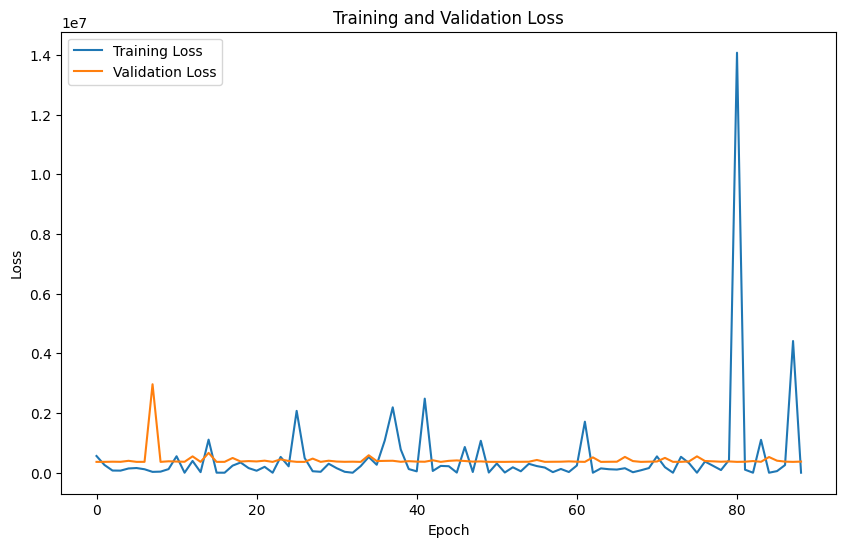

Best Hyperparameters: {'learning_rate': 0.1, 'hidden_layer_size': (32, 32), 'batch_size': 8}
Best Loss: 363436.17591694737
Test Output:  [[781.38559419]
 [781.38589584]
 [781.38562725]
 ...
 [781.3856261 ]
 [781.38589221]
 [781.38588494]]


In [106]:



# Split the data into training, validation, and test sets
split_ratio = 0.05  # 5% for validation
split_index = int(X_sample.shape[0] * split_ratio)
X_train = X_sample[split_index:]
Y_train = Y_sample[split_index:]
X_val = X_sample[:split_index]
Y_val = Y_sample[:split_index]

# Define hyperparameter search space
learning_rates = [0.1, 0.01, 0.001]
hidden_layer_sizes = [(16, 16), (32, 32),(64,64)]
batch_sizes = [16, 32,8]

best_loss = float('inf')
best_model = None
best_hyperparameters = {}

# Lists to store training and validation losses for plotting
train_losses = []
val_losses = []

# Hyperparameter tuning loop
for learning_rate in learning_rates:
    for hidden_layer_size in hidden_layer_sizes:
        for batch_size in batch_sizes:
            # Create a neural network for regression
            model_regression = CustomSequential()
            model_regression.add_layer(CustomLinearLayer(X_train.shape[1], hidden_layer_size[0]))  # Input layer
            model_regression.add_layer(CustomTanhLayer())  # Activation function (ReLU) for hidden layers
            model_regression.add_layer(CustomLinearLayer(hidden_layer_size[0], hidden_layer_size[1]))  # Hidden layer
            model_regression.add_layer(CustomTanhLayer())
            model_regression.add_layer(CustomLinearLayer(hidden_layer_size[1], 1))  # Output layer with 1 neuron for regression
            model_regression.add_layer(CustomLinearLayer(1, 1))  # Linear output layer

            # Training parameters
            num_epochs = 20000  # Increased number of training epochs
            gradient_clip = 1.0  # Gradient clipping

            # Initialize early stopping variables
            early_stopping_count = 0
            early_stopping_patience = 3

            # Training loop for regression with gradient clipping
            for epoch in range(num_epochs):
                # Shuffle the data for each epoch
                indices = np.arange(len(X_train))
                np.random.shuffle(indices)
                X_shuffled = X_train[indices]
                Y_shuffled = Y_train[indices]

                for i in range(0, len(X_train), batch_size):
                    X_batch = X_shuffled[i:i+batch_size]
                    Y_batch = Y_shuffled[i:i+batch_size]

                    # Forward pass
                    output = model_regression.forward_pass(X_batch)

                    # Calculate the Mean Squared Error (MSE) loss for regression
                    loss = np.mean((output - Y_batch) ** 2)

                    # Backpropagation with gradient clipping
                    loss_grad = 2 * (output - Y_batch) / len(X_batch)
                    model_regression.backward_pass(loss_grad)

                    # Gradient clipping to prevent exploding gradients
                    for layer in model_regression.layers_list:
                        if isinstance(layer, CustomLinearLayer):
                            layer.weights = np.clip(layer.weights, -gradient_clip, gradient_clip)

                # Calculate validation loss
                val_output = model_regression.forward_pass(X_val)
                val_loss = np.mean((val_output - Y_val) ** 2)

                # Track training and validation losses for plotting
                train_losses.append(loss)
                val_losses.append(val_loss)

#                 if epoch % 1000 == 0:
                print(f'Epoch {epoch}: Training Loss {loss}, Validation Loss {val_loss}')

                # Check for early stopping
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_model = model_regression
                    best_hyperparameters = {
                        "learning_rate": learning_rate,
                        "hidden_layer_size": hidden_layer_size,
                        "batch_size": batch_size
                    }
                    early_stopping_count = 0
                else:
                    early_stopping_count += 1
                    if early_stopping_count >= early_stopping_patience:
                        print(f"The model here has learning rate :{learning_rate}, hidden layer size {hidden_layer_size},batch size {batch_size}")
                        print()
                        break

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("Best Hyperparameters:", best_hyperparameters)
print("Best Loss:", best_loss)


test_output = best_model.forward_pass(X_test)
print("Test Output: ", test_output)
